<center>
<a href="http://www.insa-toulouse.fr/" ><img src="http://www.math.univ-toulouse.fr/~besse/Wikistat/Images/logo-insa.jpg" style="float:left; max-width: 120px; display: inline" alt="INSA"/></a> 
<a href="http://wikistat.fr/" ><img src="http://www.math.univ-toulouse.fr/~besse/Wikistat/Images/wikistat.jpg" style="max-width: 150px; display: inline"  alt="Wikistat"/></a>
<a href="http://www.math.univ-toulouse.fr/" ><img src="http://www.math.univ-toulouse.fr/~besse/Wikistat/Images/logo_imt.jpg" width=400,  style="float:right;  display: inline" alt="IMT"/> </a>
    
</center>

# High Dimensional & Deep Learning : Image classification  on MNIST dataset.

### Résumé


Ce tutoriel est en grande partie inspiré du [blog](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html) de François Chollet à l'initiative de [Keras](https://keras.io/).

## Objectives

* Use convolutonal network build image classifier on colour images
* Use pre-trained model (VGG/Inception to improve quality of the results)
* Fine-Tuned pre-trained model


## Library

In [1]:
# Utils
import sys
import os
import shutil
import time
import pickle
import numpy as np

# Deep Learning Librairies
import tensorflow as tf
import tensorflow.keras.preprocessing.image as kpi
import tensorflow.keras.layers as kl
import tensorflow.keras.optimizers as ko
import tensorflow.keras.backend as k
import tensorflow.keras.models as km
import tensorflow.keras.applications as ka

# Visualisaiton des données
from matplotlib import pyplot as plt

This code lines allow you to check if your computer is using CPU or GPU ressources. <br>
**Warning** : You won't be able to use GPU if another notebook is open and using GPU.

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3510390445197472005
]


In [3]:
MODE = "GPU" if "GPU" in [k.device_type for k in device_lib.list_local_devices()] else "CPU"
print(MODE)

CPU


## Dataset

The dataset used in this TP is the `CatsVSDogs`dataset used in a [Kaggle Contest](https://www.kaggle.com/c/dogs-vs-cats) which contains 25.000 images. It is a huge number when you do not have a lot of computation power. 

As our goal here is to understand behaviour of algorithm an not to achieve the best performances we have created two different subsambles of this dataset which is availble in the *data* directory.

* First subsample : 100 cats images and 100 dogs images for training. 40 cats images and 40 dogs images for validation.
* Second subsample : 1000 cats images and 1000 dogs images for training. 400 cats images and 400 dogs images for validation.

### Dataset organisation

To use some the image generator of keras, that we will used later, we have to organise the dataset so that each data of a same class are within the same folder. 

Our data are ten organized this way :

```
data_dir
└───subsample/
│   └───train/
│   │   └───cats/
│   │   │   │   cat.0.jpg
│   │   │   │   cat.1.jpg
│   │   │   │   ...
│   │   └───dogs/
│   │   │   │   dog.0.jpg
│   │   │   │   dog.1.jpg
│   │   │   │   ...
│   └───validation/
│   │   └───cats/
│   │   │   │   cat.1000.jpg
│   │   │   │   cat.1000.jpg
│   │   │   │   ...
│   │   └───dogs/
│   │   │   │   dog.1000.jpg
│   │   │   │   dog.1000.jpg
│   │   │   │   ...
```

###  Parameter

In [6]:
data_dir = 'data/' # chemin d'accès aux données

# subsample directory path 

N_train = 200 #2000 
N_val = 80 #800
data_dir_sub = data_dir+'subsample_%d_Ntrain_%d_Nval' %(N_train, N_val)

### Illustration des données

The `load_img` function allows to load and image as a PIL image.

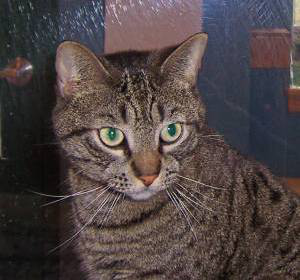

In [12]:
img = kpi.load_img(data_dir_sub+'/train/cats/cat.1.jpg')  # this is a PIL image
img

La fonction `img_to_array` génére un `array numpy` a partir d'une image PIL .

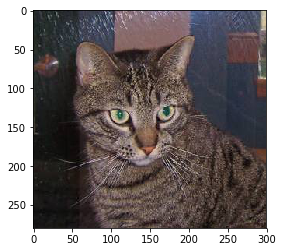

In [13]:
x = kpi.img_to_array(img)  
plt.imshow(x/255, interpolation='nearest')
plt.show()

## Pre-processing

The `ImageDataGenerator` `keras`function allow to apply different treatment on the images (transformation, normalisation). This  transformation allow to increase the size of the dataset and to make the classifier more robust.

All the possible transformaiton are listed in the documentation of the function

In [16]:
kpi.ImageDataGenerator?

Init signature:
kpi.ImageDataGenerator(
    ['featurewise_center=False', 'samplewise_center=False', 'featurewise_std_normalization=False', 'samplewise_std_normalization=False', 'zca_whitening=False', 'zca_epsilon=1e-06', 'rotation_range=0', 'width_shift_range=0.0', 'height_shift_range=0.0', 'brightness_range=None', 'shear_range=0.0', 'zoom_range=0.0', 'channel_shift_range=0.0', "fill_mode='nearest'", 'cval=0.0', 'horizontal_flip=False', 'vertical_flip=False', 'rescale=None', 'preprocessing_function=None', 'data_format=None', 'validation_split=0.0', 'dtype=None'],
)
Docstring:     
Generate batches of tensor image data with real-time data augmentation.

 The data will be looped over (in batches).

Arguments:
    featurewise_center: Boolean.
        Set input mean to 0 over the dataset, feature-wise.
    samplewise_center: Boolean. Set each sample mean to 0.
    featurewise_std_normalization: Boolean.
        Divide inputs by std of the dataset, feature-wise.
    samplewise_std_normaliza

In [17]:
datagen = kpi.ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

The`.flow()` command generate transformed images from an original image and save its in the specified directory.

In the following code we produce 8 of these transformed images.

In [24]:
img = kpi.load_img(data_dir_sub+"/train/cats/cat.1.jpg")  # this is a PIL image
x = kpi.img_to_array(img)  
x_ = np.expand_dims(x, axis=0).shape

if not(os.path.isdir(data_dir_sub+"/preprocessing_example")):
    os.mkdir(data_dir_sub+"/preprocessing_example")

    i = 0
    for batch in datagen.flow(x_, batch_size=1,save_to_dir=data_dir_sub+"/preprocessing_example", save_prefix='cat', save_format='jpeg'):
        i += 1
        if i > 7:
            break  

Display transformed images

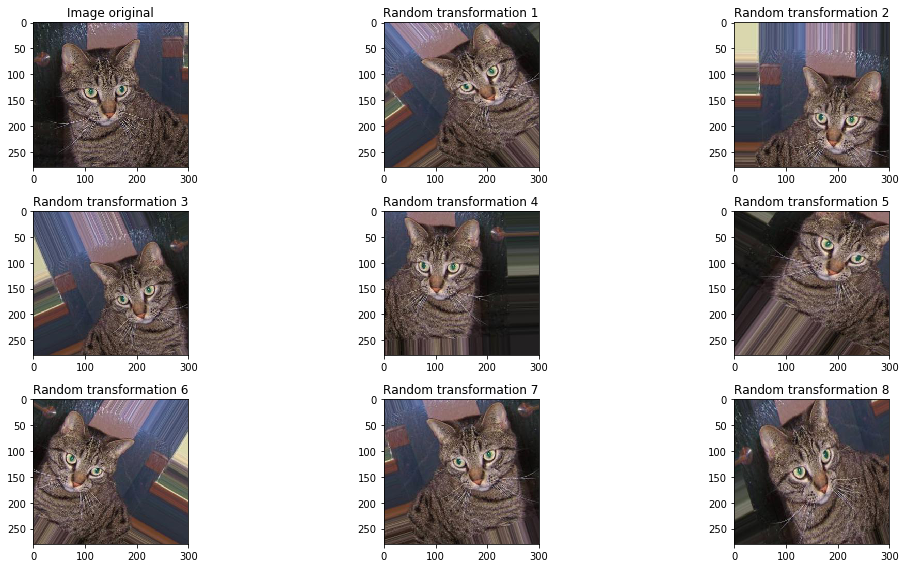

In [25]:
X_list=[]
for f in os.listdir(data_dir_sub+"/preprocessing_example"):
    X_list.append(kpi.img_to_array(kpi.load_img(data_dir_sub+"/preprocessing_example/"+f)))


fig=plt.figure(figsize=(16,8))
fig.patch.set_alpha(0)
ax = fig.add_subplot(3,3,1)
ax.imshow(x/255, interpolation="nearest")
ax.set_title("Image original")
for i,xt in enumerate(X_list):
    ax = fig.add_subplot(3,3,i+2)
    ax.imshow(xt/255, interpolation="nearest")
    ax.set_title("Random transformation %d" %(i+1))
plt.tight_layout()
plt.savefig("cats_transformation.png", dpi=100, bbox_to_anchor="tight", facecolor=fig.get_facecolor())
plt.show()

## Image classification from scratch with a convolutional network

We will here build a classifier with a custom architecture of a convolutional network.

We first defined epochs and batch_size parameters.

* `epochs`: we start with a low number (5-10) in order to check that computing time is reasonable.
* `batch_size`:When using keras Generator, size of the batch should be a divider of the size of the sample, otherwise algorithms produce very unstable results.


In [26]:
epochs = 10
batch_size=20

### Data Generation

We defined two `ImageDataGenerator` object :

* `train_datagen`: for learning, where different transformation are applied as above, in order to pass various example to the model.
* `valid_datagen`: for validation, where only rescaling is apply.

**Question** Why different transformation are applied for learning and validation?

Images have different dimensions :

In [28]:
x_0 = kpi.img_to_array(kpi.load_img(data_dir_sub+"/train/cats/cat.0.jpg"))
x_1 = kpi.img_to_array(kpi.load_img(data_dir_sub+"/train/cats/cat.1.jpg"))
x_0.shape, x_1.shape

((374, 500, 3), (280, 300, 3))

which is annoying because all images must have the same dimensions to be used in this network. 

The `flow_from_directory` methods allows to specify an output dimension in which all transformed images will be produced.

In [29]:
img_width = 150
img_height = 150

In [37]:
# this is the augmentation configuration we will use for training
train_datagen = kpi.ImageDataGenerator(
        rescale=1./255,
        rotation_range=40)

# this is the augmentation configuration we will use for testing:
# only rescaling
valid_datagen = kpi.ImageDataGenerator(rescale=1./255)

# this is a generator that will read pictures found in
# subfolers of 'data/train', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
        data_dir_sub+"/train/",  # this is the target directory
        target_size=(img_width, img_height),  
        batch_size=batch_size,
        class_mode='binary')  # since we use binary_crossentropy loss, we need binary labels

# this is a similar generator, for validation data
validation_generator = valid_datagen.flow_from_directory(
        data_dir_sub+"/validation/",
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='binary')

Found 200 images belonging to 2 classes.
Found 80 images belonging to 2 classes.


### Model architecture

The model we defined is composed of 3 convolution blocks with the follwing form : 

* A Conv2D layer with 32-3X3 filters and a `Relu` activation function.
* A MaxPooling layer with 2X2 window.

Followed by 


* A flatten layer.
* A Dense layer with 64 neurons and a Relu activation function.
* A Dropout layer with a 50% drop rate.
* A Dense layer with 1 neurons and a softmax activation function.

In [38]:
model_conv = km.Sequential()
model_conv.add(kl.Conv2D(32, (3, 3), input_shape=(img_width, img_height, 3), data_format="channels_last"))
model_conv.add(kl.Activation('relu'))
model_conv.add(kl.MaxPooling2D(pool_size=(2, 2)))

model_conv.add(kl.Conv2D(32, (3, 3)))
model_conv.add(kl.Activation('relu'))
model_conv.add(kl.MaxPooling2D(pool_size=(2, 2)))

model_conv.add(kl.Conv2D(64, (3, 3)))
model_conv.add(kl.Activation('relu'))
model_conv.add(kl.MaxPooling2D(pool_size=(2, 2)))

model_conv.add(kl.Flatten())  # this converts our 3D feature maps to 1D feature vectors
model_conv.add(kl.Dense(64))
model_conv.add(kl.Activation('relu'))
model_conv.add(kl.Dropout(0.5))
model_conv.add(kl.Dense(1))
model_conv.add(kl.Activation('sigmoid'))

model_conv.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
activation_10 (Activation)   (None, 148, 148, 32)      0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 72, 72, 32)        9248      
_________________________________________________________________
activation_11 (Activation)   (None, 72, 72, 32)        0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 34, 34, 64)        18496     
__________

As our problem here is a two classes classifier we will use the `binary_crossentropy` loss function.

In [39]:
model_conv.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])



#### Apprentissage

The training can then be done by using the `fit_generator`function instead of the `fit`function used in the MNIST notebook. This function can be used by passing generator object instead of data to the function

In [40]:
ts = time.time()
model_conv.fit_generator(train_generator, steps_per_epoch=N_train // batch_size, epochs=epochs, 
                         validation_data=validation_generator,validation_steps=N_val // batch_size)
te = time.time()
t_learning_conv_simple_model = te-ts
print("Learning TIme for %d epochs : %d seconds"%(epochs,t_learning_conv_simple_model))


Epoch 1/10
10/10 [==============================] - 3s 265ms/step - loss: 0.7696 - acc: 0.4600 - val_loss: 0.6832 - val_acc: 0.5000
Epoch 2/10
10/10 [==============================] - 2s 229ms/step - loss: 0.7019 - acc: 0.5300 - val_loss: 0.6849 - val_acc: 0.5000
Epoch 3/10
10/10 [==============================] - 2s 237ms/step - loss: 0.6796 - acc: 0.5000 - val_loss: 0.6821 - val_acc: 0.5125
Epoch 4/10
10/10 [==============================] - 3s 259ms/step - loss: 0.6735 - acc: 0.5850 - val_loss: 0.6894 - val_acc: 0.5000
Epoch 5/10
10/10 [==============================] - 3s 253ms/step - loss: 0.6707 - acc: 0.5950 - val_loss: 0.6825 - val_acc: 0.5000
Epoch 6/10
10/10 [==============================] - 2s 242ms/step - loss: 0.6707 - acc: 0.5950 - val_loss: 0.6856 - val_acc: 0.6000
Epoch 7/10
10/10 [==============================] - 2s 232ms/step - loss: 0.6797 - acc: 0.5950 - val_loss: 0.6735 - val_acc: 0.5375
Epoch 8/10
10/10 [==============================] - 3s 261ms/step - loss: 0.

#### Prédiction

In [36]:
ts = time.time()
score_conv_val = model_conv.evaluate_generator(validation_generator, N_val /batch_size, verbose=1)
score_conv_train = model_conv.evaluate_generator(train_generator, N_train / batch_size, verbose=1)
te = time.time()
t_prediction_conv_simple_model = te-ts
print('Train accuracy:', score_conv_train[1])
print('Validation accuracy:', score_conv_val[1])
print("Time Prediction: %.2f seconds" %t_prediction_conv_simple_model )

10/10 [==============================] - 1s 69ms/step - loss: 0.2952 - acc: 0.8850
Train accuracy: 0.885
Validation accuracy: 0.625
Time Prediction: 1.16 seconds


**Q** Comments the accuracy and loss value for training and validation to the one observe in the last epochs of training. What do you observe? Is this normal.

**Q** What can you say about the performance of this model?

**Exercice** Add more transformation to the learning generator. Does it help?

## Pre-trained Network

We have seen above that the complexity of the data make it difficult to build quickly an effecient classifier from scratch event with a elaborate method as a convolutional network.

We will now see that this problem can easily be tackle by using **pre-trained models**. These models are models that are very complex (see image below). They have been trained on very huge amount of image data in order to classify them. 

The figure below represent a *VGG 16*. This model is composed of *5 convolutional blocks* which allows to build features on the images. The last block is a *fully convolutional block*. This last block can be seen as a simple *MLP model* which is used on the features build by the convolutional block.

How this model, designed to solve a different problem that our problem can be helpfull?

Here is our two-stage strategy :  
1. we will send our data through the 5 convolutional block in order to build features. These block have been trained on a huge amount of data and can then build intelligent features.
2. we will build our own MLP classifier designed to solved our CatsVsDogs problem, and we will trained it on the features build on step one


### Illustration du réseau

![](https://blog.keras.io/img/imgclf/vgg16_original.png)

### Step 1 Build features

#### Download weight of the 5 blocks convolutional layer.

We will now download the weight of a VGG16 models that havec been learned on the [image-net](http://www.image-net.org) dataset. The image-net is composed of millions of images for 1000 categories.

If it's the first time you use these weights, you will have to download it (it will start automatically) and they will be save in your home 
`"~/.keras/models"`

The *include_top* argument of the `VGG16`application allows to precised if we want to use or not the last block (fully-connected later)


In [42]:
model_VGG16_without_top = ka.VGG16(include_top=False, weights='imagenet')
model_VGG16_without_top.summary()

58892288/58889256 [==============================] - 8s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool

#### Building features

We will now send our data to this model we loaded in order to build our features.

In [43]:
datagen = kpi.ImageDataGenerator(rescale=1. / 255)

generator = datagen.flow_from_directory(
        data_dir_sub+"/train",
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,  # this means our generator will only yield batches of data, no labels
        shuffle=False)  
features_train = model_VGG16_without_top.predict_generator(generator, N_train / batch_size,  verbose = 1)


generator = datagen.flow_from_directory(
    data_dir_sub+"/validation",
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)
features_validation = model_VGG16_without_top.predict_generator(generator, N_val / batch_size,  verbose = 1)    

Found 200 images belonging to 2 classes.
10/10 [==============================] - 11s 1s/step
Found 80 images belonging to 2 classes.
4/4 [==============================] - 5s 1s/step


### Step 2 Building our classifier on top of features

We will know build a simple classifier in order to used the previously build features to classify our data.


#### Training
**Exercise** Write this classifier 

In [48]:
# %load solutions/classifier_pretrained_model.py

We know save the weights of this classifier to be used later.

### Prediction

In [50]:
ts = time.time()
score_VGG_fcm_val = model_VGG_fcm.evaluate(features_validation, validation_labels)
score_VGG_fcm_train = model_VGG_fcm.evaluate(features_train, train_labels)
te = time.time()
t_prediction_VGG_fcm = te-ts
print('Train accuracy:', score_VGG_fcm_train[1])
print('Validation accuracy:', score_VGG_fcm_val[1])
print("Time Prediction: %.2f seconds" %t_prediction_VGG_fcm)

200/200 [==============================] - 0s 40us/sample - loss: 0.0412 - acc: 1.0000
Train accuracy: 1.0
Validation accuracy: 0.9375
Time Prediction: 0.02 seconds


**Q** Comment the performance of this new model

In [51]:
model_VGG_fcm.save_weights(data_dir_sub+'/weights_model_VGG_fully_connected_model_%d_epochs_%d_batch_size.h5' %(epochs, batch_size))

## Fine Tuning

We have notably increase the performance of our model with a model thant is really quick. We can continue to try improve our results by modifying the small MLP classifier network we build?
 
But to really improve our model, it would be nice to also change the weight of the previous layer in order to make them fit our problem.
This is possible and it's called FineTuning.

In this part we will then build a Model which is composed of the 5 convolutonal block of the VGG model (with it weights learning on image net) and the classifier block we build (with the weight that we have learned previously).

![](https://blog.keras.io/img/imgclf/vgg16_modified.png)

### Model creation.

We first download the model as done previously.

However, the model will be trained on our image, we then have to specify the input_shape of our data.


In [53]:
# build the VGG16 network
model_VGG16_without_top = ka.VGG16(include_top=False, weights='imagenet', input_shape=(img_height, img_width, 3))
print('Model loaded.')

Model loaded.


We then build a classfier model like the one we build above and we load the learned weight.

In [54]:
# build a classifier model to put on top of the convolutional model
top_model = km.Sequential()
top_model.add(kl.Flatten(input_shape=model_VGG16_without_top.output_shape[1:]))
top_model.add(kl.Dense(64, activation='relu'))
top_model.add(kl.Dropout(0.5))
top_model.add(kl.Dense(1, activation='sigmoid'))

top_model.load_weights(data_dir_sub+'/weights_model_VGG_fully_connected_model_%d_epochs_%d_batch_size.h5' %(epochs, batch_size))


Finally we assemble these two models

In [55]:
# add the model on top of the convolutional base
model_VGG_LastConv_fcm = km.Model(inputs=model_VGG16_without_top.input, outputs=top_model(model_VGG16_without_top.output))

model_VGG_LastConv_fcm.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

### Freezed block

Our model is ready to be fine-tuned! 

However, as seen above it containes a huge number of parameters that our computer may not handle.

We will start by fine-tuned only the last block of convolution and our classifier. 

This is possible by updating the trainable arguments of the layers that we don't want to be updated.

In [57]:
for layer in model_VGG_LastConv_fcm.layers[:15]:
    layer.trainable = False

### Generate Data

In [58]:
# prepare data augmentation configuration
train_datagen = kpi.ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = kpi.ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    data_dir_sub+"/train/",
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    data_dir_sub+"/validation/",
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary')


Found 200 images belonging to 2 classes.
Found 80 images belonging to 2 classes.


### Training

In [59]:
model_VGG_LastConv_fcm.compile(loss='binary_crossentropy',
              optimizer=ko.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])


# fine-tune the model
ts = time.time()
model_VGG_LastConv_fcm.fit_generator(
    train_generator,
    steps_per_epoch=N_train // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=N_val // batch_size)
te = time.time()
t_learning_VGG_LastConv_fcm = te-ts


Epoch 1/10
10/10 [==============================] - 19s 2s/step - loss: 0.2181 - acc: 0.9050 - val_loss: 0.1933 - val_acc: 0.9375
Epoch 2/10
10/10 [==============================] - 20s 2s/step - loss: 0.1699 - acc: 0.9450 - val_loss: 0.2052 - val_acc: 0.9500
Epoch 3/10
10/10 [==============================] - 20s 2s/step - loss: 0.1973 - acc: 0.9150 - val_loss: 0.1868 - val_acc: 0.9500
Epoch 4/10
10/10 [==============================] - 21s 2s/step - loss: 0.1766 - acc: 0.9450 - val_loss: 0.1871 - val_acc: 0.9625
Epoch 5/10
10/10 [==============================] - 21s 2s/step - loss: 0.1774 - acc: 0.9350 - val_loss: 0.1957 - val_acc: 0.9500
Epoch 6/10
10/10 [==============================] - 20s 2s/step - loss: 0.1356 - acc: 0.9500 - val_loss: 0.1820 - val_acc: 0.9625
Epoch 7/10
10/10 [==============================] - 20s 2s/step - loss: 0.1786 - acc: 0.9300 - val_loss: 0.1779 - val_acc: 0.9375
Epoch 8/10
10/10 [==============================] - 20s 2s/step - loss: 0.1338 - acc: 0.96

KeyboardInterrupt: 

###  Prediction

In [61]:
ts = time.time()
score_VGG_LastConv_fcm_val = model_VGG_LastConv_fcm.evaluate_generator(validation_generator, N_val // batch_size, verbose=1)
score_VGG_LastConv_fcm_train = model_VGG_LastConv_fcm.evaluate_generator(train_generator, N_train // batch_size, verbose=1)

te = time.time()
t_prediction_VGG_LastConv_fcm = te-ts
print('Train accuracy:', score_VGG_LastConv_fcm_val[1])
print('Validation accuracy:', score_VGG_LastConv_fcm_train[1])
print("Time Prediction: %.2f seconds" %t_prediction_VGG_LastConv_fcm)

10/10 [==============================] - 13s 1s/step - loss: 0.0927 - acc: 0.9750
Train accuracy: 0.9625
Validation accuracy: 0.975
Time Prediction: 18.26 seconds


## Prediction on Kaggle Dataset

Let's see now how our trained model perform on the kaggle real test dataset (data/test)

**Exercise** Apply the model to this dataset and display results on a sample to check it performs well

Found 200 images belonging to 1 classes.
10/10 [==============================] - 12s 1s/step


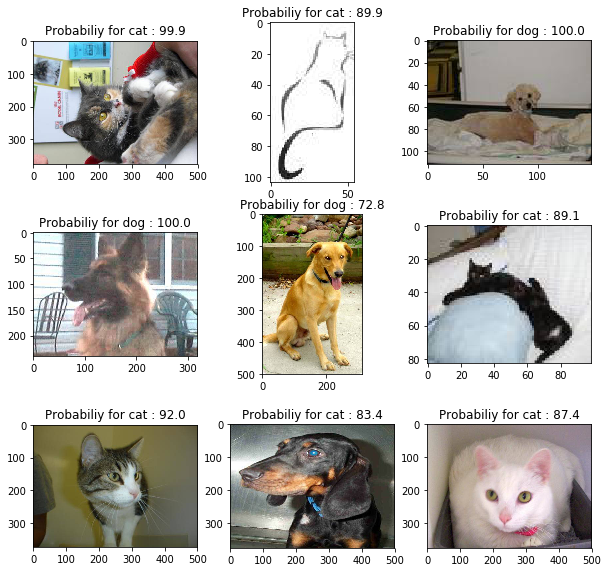

In [68]:
# %load solutions/test_kaggle.py

## Exercised

Keras Has a lot of pre-trained model

* Xception
* VGG16
* VGG19
* ResNet50
* InceptionV3
* InceptionResNetV2
* MobileNet

Some have a lot more complex architecture like `InceptionV3`.

**Exercice** Restart the TP by using a different pre-trained model and apply the required modification